In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [20]:
# 定义CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1)# 输入通道数为1，输出通道数为16，卷积核大小为3
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)# 池化层
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1)# 输入通道数为16，输出通道数为32，卷积核大小为3
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1)# 输入通道数为32，输出通道数为64，卷积核大小为3
        self.fc1 = nn.Linear(64 * 3, 128)# 全连接层
        self.fc2 = nn.Linear(128, 1)# 二分类问题，输出为1 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x= self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [21]:
# 自定义数据集类
class BikeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [22]:

# 准备训练数据和标签
df = pd.read_csv('./1234.csv')

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
df["minute"] = df.index.minute
df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month
# df["year"] = df.index.year
# 将加载的csv文件按9:1的比例分为训练集和测试集
features = df[['day_of_week', 'month', 'day_of_month', 'hour', 'minute', 'weather', 'tem', 'holiday']].values
labels = df[['cnt']].values
df = df.dropna()
df = df.drop_duplicates()
df = df.sample(frac=1)
df.head()
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.1, random_state=42)
train_features = torch.from_numpy(train_features).float()
train_labels = torch.from_numpy(train_labels).float()
val_features = torch.from_numpy(val_features).float()
val_labels = torch.from_numpy(val_labels).float()

train_dataset = BikeDataset(train_features, train_labels)
val_dataset = BikeDataset(val_features, val_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



In [23]:
model = CNN()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# 训练模型
# 训练模型
train_loss_history = []
train_accuracy_history = []
val_accuracy_history = []
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for data, targets in progress_bar:
        optimizer.zero_grad()
        outputs = model(data.unsqueeze(1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        predicted = torch.round(outputs)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        progress_bar.set_postfix({'Training Loss': loss.item(),'Training Accuracy': correct / total})

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / total
    train_accuracy_history.append(train_accuracy)
    # 验证模型
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
         for data, targets in val_loader:
            outputs = model(data.unsqueeze(1))
            loss = criterion(outputs, targets)
            val_loss += loss.item() * data.size(0)

            # 计算验证集的精度
            predicted = torch.round(outputs)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total * 100

    # 打印训练和验证结果
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print("-------------------------")

Epoch 1/400:
Training Loss: 11514.8897
Validation Loss: 9840.3149
Validation Accuracy: 0.00%
-------------------------


Epoch 2/400:
Training Loss: 9994.2591
Validation Loss: 9364.9210
Validation Accuracy: 0.39%
-------------------------


Epoch 3/400:
Training Loss: 9524.4715
Validation Loss: 9207.2025
Validation Accuracy: 0.55%
-------------------------


Epoch 4/400:
Training Loss: 9226.8892
Validation Loss: 8916.8462
Validation Accuracy: 0.47%
-------------------------


Epoch 5/400:
Training Loss: 8857.5540
Validation Loss: 8554.2068
Validation Accuracy: 0.39%
-------------------------


Epoch 6/400:
Training Loss: 8572.6449
Validation Loss: 8409.0187
Validation Accuracy: 0.86%
-------------------------


Epoch 7/400:
Training Loss: 8419.2460
Validation Loss: 8349.7165
Validation Accuracy: 0.31%
-------------------------


Epoch 8/400:
Training Loss: 8337.3303
Validation Loss: 8236.1396
Validation Accuracy: 0.70%
-------------------------


Epoch 9/400:
Training Loss: 8242.3217
Validation Loss: 8147.3491
Validation Accuracy: 0.86%
-------------------------


Epoch 10/400:
Training Loss: 8165.2199
Validation Loss: 8127.4463
Validation Accuracy: 0.86%
-------------------------


Epoch 11/400:
Training Loss: 8076.2712
Validation Loss: 7972.2585
Validation Accuracy: 0.70%
-------------------------


Epoch 12/400:
Training Loss: 7993.4167
Validation Loss: 7871.8334
Validation Accuracy: 0.70%
-------------------------


Epoch 13/400:
Training Loss: 7907.2510
Validation Loss: 7855.3402
Validation Accuracy: 0.86%
-------------------------


Epoch 14/400:
Training Loss: 7832.2448
Validation Loss: 7829.3838
Validation Accuracy: 0.70%
-------------------------


Epoch 15/400:
Training Loss: 7785.3461
Validation Loss: 7646.4101
Validation Accuracy: 1.01%
-------------------------


Epoch 16/400:
Training Loss: 7684.1758
Validation Loss: 7626.5573
Validation Accuracy: 0.86%
-------------------------


Epoch 17/400:
Training Loss: 7614.3333
Validation Loss: 7560.5919
Validation Accuracy: 1.09%
-------------------------


Epoch 18/400:
Training Loss: 7555.2226
Validation Loss: 7405.4665
Validation Accuracy: 0.47%
-------------------------


Epoch 19/400:
Training Loss: 7491.9375
Validation Loss: 7516.9051
Validation Accuracy: 0.86%
-------------------------


Epoch 20/400:
Training Loss: 7430.1862
Validation Loss: 7272.1576
Validation Accuracy: 0.62%
-------------------------


Epoch 21/400:
Training Loss: 7349.9581
Validation Loss: 7256.6210
Validation Accuracy: 0.94%
-------------------------


Epoch 22/400:
Training Loss: 7322.6322
Validation Loss: 7160.6738
Validation Accuracy: 1.09%
-------------------------


Epoch 23/400:
Training Loss: 7258.7685
Validation Loss: 7128.8123
Validation Accuracy: 1.17%
-------------------------


Epoch 24/400:
Training Loss: 7219.4531
Validation Loss: 7094.4641
Validation Accuracy: 1.56%
-------------------------


Epoch 25/400:
Training Loss: 7179.6249
Validation Loss: 7308.9646
Validation Accuracy: 0.39%
-------------------------


Epoch 26/400:
Training Loss: 7151.5791
Validation Loss: 7056.3747
Validation Accuracy: 1.01%
-------------------------


Epoch 27/400:
Training Loss: 7110.6108
Validation Loss: 6998.1786
Validation Accuracy: 1.17%
-------------------------


Epoch 28/400:
Training Loss: 7080.5909
Validation Loss: 6925.2337
Validation Accuracy: 1.09%
-------------------------


Epoch 29/400:
Training Loss: 7025.5252
Validation Loss: 6890.5472
Validation Accuracy: 1.33%
-------------------------


Epoch 30/400:
Training Loss: 6987.5661
Validation Loss: 6881.9867
Validation Accuracy: 1.25%
-------------------------


Epoch 31/400:
Training Loss: 6943.2609
Validation Loss: 7037.1430
Validation Accuracy: 0.55%
-------------------------


Epoch 32/400:
Training Loss: 6967.5963
Validation Loss: 6815.6889
Validation Accuracy: 0.86%
-------------------------


Epoch 33/400:
Training Loss: 6919.6537
Validation Loss: 6799.5150
Validation Accuracy: 0.70%
-------------------------


Epoch 34/400:
Training Loss: 6880.6031
Validation Loss: 6747.3957
Validation Accuracy: 1.01%
-------------------------


Epoch 35/400:
Training Loss: 6888.8033
Validation Loss: 6846.9820
Validation Accuracy: 1.40%
-------------------------


Epoch 36/400:
Training Loss: 6854.9793
Validation Loss: 6693.5810
Validation Accuracy: 1.40%
-------------------------


Epoch 37/400:
Training Loss: 6813.3996
Validation Loss: 6734.2673
Validation Accuracy: 1.33%
-------------------------


Epoch 38/400:
Training Loss: 6803.5075
Validation Loss: 6678.4869
Validation Accuracy: 1.48%
-------------------------


Epoch 39/400:
Training Loss: 6796.0450
Validation Loss: 6658.2064
Validation Accuracy: 1.25%
-------------------------


Epoch 40/400:
Training Loss: 6792.0145
Validation Loss: 6663.6042
Validation Accuracy: 1.17%
-------------------------


Epoch 41/400:
Training Loss: 6742.7824
Validation Loss: 6649.5756
Validation Accuracy: 1.33%
-------------------------


Epoch 42/400:
Training Loss: 6721.6659
Validation Loss: 6580.8409
Validation Accuracy: 0.78%
-------------------------


Epoch 43/400:
Training Loss: 6663.1201
Validation Loss: 6581.3739
Validation Accuracy: 1.56%
-------------------------


Epoch 44/400:
Training Loss: 6669.7452
Validation Loss: 6513.8237
Validation Accuracy: 1.33%
-------------------------


Epoch 45/400:
Training Loss: 6647.9991
Validation Loss: 6491.9746
Validation Accuracy: 1.79%
-------------------------


Epoch 46/400:
Training Loss: 6615.3529
Validation Loss: 6485.3753
Validation Accuracy: 1.79%
-------------------------


Epoch 47/400:
Training Loss: 6608.2997
Validation Loss: 6459.2486
Validation Accuracy: 1.72%
-------------------------


Epoch 48/400:
Training Loss: 6582.2976
Validation Loss: 6464.8327
Validation Accuracy: 1.17%
-------------------------


Epoch 49/400:
Training Loss: 6564.2992
Validation Loss: 6426.4857
Validation Accuracy: 1.48%
-------------------------


Epoch 50/400:
Training Loss: 6559.7077
Validation Loss: 6439.4540
Validation Accuracy: 2.26%
-------------------------


Epoch 51/400:
Training Loss: 6581.8658
Validation Loss: 6492.5310
Validation Accuracy: 1.48%
-------------------------


Epoch 52/400:
Training Loss: 6492.6061
Validation Loss: 6395.0944
Validation Accuracy: 1.56%
-------------------------


Epoch 53/400:
Training Loss: 6505.2744
Validation Loss: 6464.6719
Validation Accuracy: 1.64%
-------------------------


Epoch 54/400:
Training Loss: 6479.5352
Validation Loss: 6426.3868
Validation Accuracy: 1.33%
-------------------------


Epoch 55/400:
Training Loss: 6440.9491
Validation Loss: 6342.7231
Validation Accuracy: 2.18%
-------------------------


Epoch 56/400:
Training Loss: 6435.9291
Validation Loss: 6294.4365
Validation Accuracy: 1.72%
-------------------------


Epoch 57/400:
Training Loss: 6444.8612
Validation Loss: 6284.8771
Validation Accuracy: 1.95%
-------------------------


Epoch 58/400:
Training Loss: 6411.9603
Validation Loss: 6259.4826
Validation Accuracy: 2.03%
-------------------------


Epoch 59/400:
Training Loss: 6376.0705
Validation Loss: 6260.0775
Validation Accuracy: 1.87%
-------------------------


Epoch 60/400:
Training Loss: 6386.3009
Validation Loss: 6419.2704
Validation Accuracy: 2.42%
-------------------------


Epoch 61/400:
Training Loss: 6346.3807
Validation Loss: 6223.2721
Validation Accuracy: 2.34%
-------------------------


Epoch 62/400:
Training Loss: 6342.9176
Validation Loss: 6250.2310
Validation Accuracy: 1.95%
-------------------------


Epoch 63/400:
Training Loss: 6322.6933
Validation Loss: 6178.5127
Validation Accuracy: 2.73%
-------------------------


Epoch 64/400:
Training Loss: 6327.8106
Validation Loss: 6352.2497
Validation Accuracy: 3.28%
-------------------------


Epoch 65/400:
Training Loss: 6311.3720
Validation Loss: 6278.6459
Validation Accuracy: 3.82%
-------------------------


Epoch 66/400:
Training Loss: 6302.1752
Validation Loss: 6111.8025
Validation Accuracy: 3.82%
-------------------------


Epoch 67/400:
Training Loss: 6287.4241
Validation Loss: 6157.0127
Validation Accuracy: 3.28%
-------------------------


Epoch 68/400:
Training Loss: 6254.7398
Validation Loss: 6216.7740
Validation Accuracy: 3.67%
-------------------------


Epoch 69/400:
Training Loss: 6228.5857
Validation Loss: 6124.5523
Validation Accuracy: 3.43%
-------------------------


Epoch 70/400:
Training Loss: 6231.2765
Validation Loss: 6235.2575
Validation Accuracy: 3.98%
-------------------------


Epoch 71/400:
Training Loss: 6215.5633
Validation Loss: 6087.9052
Validation Accuracy: 4.91%
-------------------------


Epoch 72/400:
Training Loss: 6224.6510
Validation Loss: 6114.5965
Validation Accuracy: 4.06%
-------------------------


Epoch 73/400:
Training Loss: 6193.1114
Validation Loss: 6060.0250
Validation Accuracy: 3.82%
-------------------------


Epoch 74/400:
Training Loss: 6217.9875
Validation Loss: 6024.5949
Validation Accuracy: 4.06%
-------------------------


Epoch 75/400:
Training Loss: 6188.9290
Validation Loss: 6019.5978
Validation Accuracy: 4.60%
-------------------------


Epoch 76/400:
Training Loss: 6165.8657
Validation Loss: 5961.9369
Validation Accuracy: 4.60%
-------------------------


Epoch 77/400:
Training Loss: 6131.1851
Validation Loss: 6319.1504
Validation Accuracy: 4.76%
-------------------------


Epoch 78/400:
Training Loss: 6109.3615
Validation Loss: 6035.0022
Validation Accuracy: 4.84%
-------------------------


Epoch 79/400:
Training Loss: 6102.4590
Validation Loss: 5893.2034
Validation Accuracy: 4.52%
-------------------------


Epoch 80/400:
Training Loss: 6101.2736
Validation Loss: 6310.6201
Validation Accuracy: 4.52%
-------------------------


Epoch 81/400:
Training Loss: 6097.2407
Validation Loss: 5925.5385
Validation Accuracy: 3.90%
-------------------------


Epoch 82/400:
Training Loss: 6074.5442
Validation Loss: 5883.5607
Validation Accuracy: 4.99%
-------------------------


Epoch 83/400:
Training Loss: 6030.3627
Validation Loss: 5903.1047
Validation Accuracy: 4.37%
-------------------------


Epoch 84/400:
Training Loss: 6031.6358
Validation Loss: 5896.7243
Validation Accuracy: 4.29%
-------------------------


Epoch 85/400:
Training Loss: 6063.4204
Validation Loss: 5876.8965
Validation Accuracy: 3.90%
-------------------------


Epoch 86/400:
Training Loss: 5998.9403
Validation Loss: 5893.0727
Validation Accuracy: 4.76%
-------------------------


Epoch 87/400:
Training Loss: 5976.8692
Validation Loss: 5942.1364
Validation Accuracy: 4.29%
-------------------------


Epoch 88/400:
Training Loss: 5966.5449
Validation Loss: 5872.6249
Validation Accuracy: 4.45%
-------------------------


Epoch 89/400:
Training Loss: 5940.0766
Validation Loss: 5811.5603
Validation Accuracy: 3.90%
-------------------------


Epoch 90/400:
Training Loss: 5941.9697
Validation Loss: 5730.2992
Validation Accuracy: 4.45%
-------------------------


Epoch 91/400:
Training Loss: 5932.4589
Validation Loss: 5768.7626
Validation Accuracy: 4.68%
-------------------------


Epoch 92/400:
Training Loss: 5887.8633
Validation Loss: 5752.6975
Validation Accuracy: 4.84%
-------------------------


Epoch 93/400:
Training Loss: 5897.2601
Validation Loss: 5746.9183
Validation Accuracy: 4.60%
-------------------------


Epoch 94/400:
Training Loss: 5871.6621
Validation Loss: 5781.2682
Validation Accuracy: 4.68%
-------------------------


Epoch 95/400:
Training Loss: 5847.0581
Validation Loss: 5708.6725
Validation Accuracy: 3.90%
-------------------------


Epoch 96/400:
Training Loss: 5861.3278
Validation Loss: 5641.7781
Validation Accuracy: 4.45%
-------------------------


Epoch 97/400:
Training Loss: 5818.0061
Validation Loss: 5876.3653
Validation Accuracy: 4.45%
-------------------------


Epoch 98/400:
Training Loss: 5822.5255
Validation Loss: 5707.4839
Validation Accuracy: 3.82%
-------------------------


Epoch 99/400:
Training Loss: 5784.8697
Validation Loss: 5786.2132
Validation Accuracy: 3.90%
-------------------------


Epoch 100/400:
Training Loss: 5797.3400
Validation Loss: 5599.1618
Validation Accuracy: 4.13%
-------------------------


Epoch 101/400:
Training Loss: 5768.2113
Validation Loss: 5579.2115
Validation Accuracy: 4.60%
-------------------------


Epoch 102/400:
Training Loss: 5761.8875
Validation Loss: 5596.9232
Validation Accuracy: 4.60%
-------------------------


Epoch 103/400:
Training Loss: 5720.3897
Validation Loss: 5549.1071
Validation Accuracy: 4.84%
-------------------------


Epoch 104/400:
Training Loss: 5730.8529
Validation Loss: 5709.8581
Validation Accuracy: 4.37%
-------------------------


Epoch 105/400:
Training Loss: 5724.4663
Validation Loss: 5528.4974
Validation Accuracy: 4.45%
-------------------------


Epoch 106/400:
Training Loss: 5691.5789
Validation Loss: 5575.8571
Validation Accuracy: 4.52%
-------------------------


Epoch 107/400:
Training Loss: 5686.0644
Validation Loss: 5548.0002
Validation Accuracy: 4.29%
-------------------------


Epoch 108/400:
Training Loss: 5683.9137
Validation Loss: 5434.9776
Validation Accuracy: 3.90%
-------------------------


Epoch 109/400:
Training Loss: 5669.2273
Validation Loss: 5483.5918
Validation Accuracy: 4.29%
-------------------------


Epoch 110/400:
Training Loss: 5658.5729
Validation Loss: 5664.6210
Validation Accuracy: 4.45%
-------------------------


Epoch 111/400:
Training Loss: 5650.7796
Validation Loss: 5556.4341
Validation Accuracy: 4.52%
-------------------------


Epoch 112/400:
Training Loss: 5614.1212
Validation Loss: 5718.8465
Validation Accuracy: 4.45%
-------------------------


Epoch 113/400:
Training Loss: 5617.2618
Validation Loss: 5585.1129
Validation Accuracy: 4.21%
-------------------------


Epoch 114/400:
Training Loss: 5587.3513
Validation Loss: 5405.6561
Validation Accuracy: 4.21%
-------------------------


Epoch 115/400:
Training Loss: 5582.3076
Validation Loss: 5536.9695
Validation Accuracy: 4.06%
-------------------------


Epoch 116/400:
Training Loss: 5599.2045
Validation Loss: 5380.1241
Validation Accuracy: 3.90%
-------------------------


Epoch 117/400:
Training Loss: 5561.9719
Validation Loss: 5417.4504
Validation Accuracy: 4.29%
-------------------------


Epoch 118/400:
Training Loss: 5541.4791
Validation Loss: 5366.2266
Validation Accuracy: 3.59%
-------------------------


Epoch 119/400:
Training Loss: 5592.5580
Validation Loss: 5347.8133
Validation Accuracy: 4.21%
-------------------------


Epoch 120/400:
Training Loss: 5562.0750
Validation Loss: 5354.5405
Validation Accuracy: 4.37%
-------------------------


Epoch 121/400:
Training Loss: 5498.9192
Validation Loss: 5318.7710
Validation Accuracy: 3.74%
-------------------------


Epoch 122/400:
Training Loss: 5506.2720
Validation Loss: 5302.9524
Validation Accuracy: 4.52%
-------------------------


Epoch 123/400:
Training Loss: 5489.9722
Validation Loss: 5357.9901
Validation Accuracy: 4.06%
-------------------------


Epoch 124/400:
Training Loss: 5496.6192
Validation Loss: 5518.5587
Validation Accuracy: 4.29%
-------------------------


Epoch 125/400:
Training Loss: 5510.1302
Validation Loss: 5289.7167
Validation Accuracy: 3.98%
-------------------------


Epoch 126/400:
Training Loss: 5439.7399
Validation Loss: 5294.3046
Validation Accuracy: 3.98%
-------------------------


Epoch 127/400:
Training Loss: 5471.5690
Validation Loss: 5283.3101
Validation Accuracy: 4.52%
-------------------------


Epoch 128/400:
Training Loss: 5439.5746
Validation Loss: 5260.4862
Validation Accuracy: 4.13%
-------------------------


Epoch 129/400:
Training Loss: 5423.0938
Validation Loss: 5261.0340
Validation Accuracy: 4.21%
-------------------------


Epoch 130/400:
Training Loss: 5422.7425
Validation Loss: 5211.2775
Validation Accuracy: 4.52%
-------------------------


Epoch 131/400:
Training Loss: 5404.1190
Validation Loss: 5220.1816
Validation Accuracy: 3.59%
-------------------------


Epoch 132/400:
Training Loss: 5394.3827
Validation Loss: 5258.4218
Validation Accuracy: 3.82%
-------------------------


Epoch 133/400:
Training Loss: 5374.3274
Validation Loss: 5186.2198
Validation Accuracy: 4.13%
-------------------------


Epoch 134/400:
Training Loss: 5409.4565
Validation Loss: 5177.7929
Validation Accuracy: 3.90%
-------------------------


Epoch 135/400:
Training Loss: 5362.3942
Validation Loss: 5207.6735
Validation Accuracy: 3.43%
-------------------------


Epoch 136/400:
Training Loss: 5394.1008
Validation Loss: 5466.0105
Validation Accuracy: 4.21%
-------------------------


Epoch 137/400:
Training Loss: 5360.9349
Validation Loss: 5315.5735
Validation Accuracy: 3.67%
-------------------------


Epoch 138/400:
Training Loss: 5332.5906
Validation Loss: 5096.9016
Validation Accuracy: 3.51%
-------------------------


Epoch 139/400:
Training Loss: 5355.8994
Validation Loss: 5296.9624
Validation Accuracy: 3.90%
-------------------------


Epoch 140/400:
Training Loss: 5341.8171
Validation Loss: 5154.6706
Validation Accuracy: 3.82%
-------------------------


Epoch 141/400:
Training Loss: 5303.8654
Validation Loss: 5135.0144
Validation Accuracy: 3.82%
-------------------------


Epoch 142/400:
Training Loss: 5301.4261
Validation Loss: 5594.9058
Validation Accuracy: 3.98%
-------------------------


Epoch 143/400:
Training Loss: 5297.5174
Validation Loss: 5065.3557
Validation Accuracy: 4.29%
-------------------------


Epoch 144/400:
Training Loss: 5280.8718
Validation Loss: 5134.9216
Validation Accuracy: 4.29%
-------------------------


Epoch 145/400:
Training Loss: 5290.8798
Validation Loss: 5124.0691
Validation Accuracy: 3.35%
-------------------------


Epoch 146/400:
Training Loss: 5261.6286
Validation Loss: 5065.4025
Validation Accuracy: 3.51%
-------------------------


Epoch 147/400:
Training Loss: 5263.6957
Validation Loss: 5020.9039
Validation Accuracy: 4.52%
-------------------------


Epoch 148/400:
Training Loss: 5227.7045
Validation Loss: 5236.2976
Validation Accuracy: 3.74%
-------------------------


Epoch 149/400:
Training Loss: 5236.5473
Validation Loss: 5885.8234
Validation Accuracy: 3.51%
-------------------------


Epoch 150/400:
Training Loss: 5225.9807
Validation Loss: 5112.9660
Validation Accuracy: 3.67%
-------------------------


Epoch 151/400:
Training Loss: 5208.3414
Validation Loss: 4983.9753
Validation Accuracy: 4.37%
-------------------------


Epoch 152/400:
Training Loss: 5194.0991
Validation Loss: 4992.2985
Validation Accuracy: 4.29%
-------------------------


Epoch 153/400:
Training Loss: 5185.3738
Validation Loss: 4977.3639
Validation Accuracy: 4.06%
-------------------------


Epoch 154/400:
Training Loss: 5203.2841
Validation Loss: 5107.3834
Validation Accuracy: 3.98%
-------------------------


Epoch 155/400:
Training Loss: 5163.2471
Validation Loss: 4978.8883
Validation Accuracy: 3.82%
-------------------------


Epoch 156/400:
Training Loss: 5159.9206
Validation Loss: 4936.2554
Validation Accuracy: 4.21%
-------------------------


Epoch 157/400:
Training Loss: 5166.0222
Validation Loss: 5153.9041
Validation Accuracy: 4.37%
-------------------------


Epoch 158/400:
Training Loss: 5172.1424
Validation Loss: 4950.1964
Validation Accuracy: 3.98%
-------------------------


Epoch 159/400:
Training Loss: 5185.9079
Validation Loss: 4927.6760
Validation Accuracy: 3.59%
-------------------------


Epoch 160/400:
Training Loss: 5156.5118
Validation Loss: 4925.2662
Validation Accuracy: 3.28%
-------------------------


Epoch 161/400:
Training Loss: 5127.4199
Validation Loss: 4918.9118
Validation Accuracy: 3.74%
-------------------------


Epoch 162/400:
Training Loss: 5127.0699
Validation Loss: 5050.3844
Validation Accuracy: 4.06%
-------------------------


Epoch 163/400:
Training Loss: 5138.7775
Validation Loss: 4884.8380
Validation Accuracy: 3.74%
-------------------------


Epoch 164/400:
Training Loss: 5138.8409
Validation Loss: 4914.9298
Validation Accuracy: 3.51%
-------------------------


Epoch 165/400:
Training Loss: 5104.5010
Validation Loss: 4945.9001
Validation Accuracy: 3.82%
-------------------------


Epoch 166/400:
Training Loss: 5083.4108
Validation Loss: 4874.8196
Validation Accuracy: 4.06%
-------------------------


Epoch 167/400:
Training Loss: 5086.3011
Validation Loss: 4827.1621
Validation Accuracy: 4.13%
-------------------------


Epoch 168/400:
Training Loss: 5076.1890
Validation Loss: 4940.5003
Validation Accuracy: 3.28%
-------------------------


Epoch 169/400:
Training Loss: 5062.6080
Validation Loss: 4828.6865
Validation Accuracy: 3.74%
-------------------------


Epoch 170/400:
Training Loss: 5015.7245
Validation Loss: 4885.2286
Validation Accuracy: 3.74%
-------------------------


Epoch 171/400:
Training Loss: 5024.0430
Validation Loss: 4806.9556
Validation Accuracy: 4.06%
-------------------------


Epoch 172/400:
Training Loss: 5014.6820
Validation Loss: 4890.6366
Validation Accuracy: 3.98%
-------------------------


Epoch 173/400:
Training Loss: 5035.7540
Validation Loss: 4848.2673
Validation Accuracy: 3.90%
-------------------------


Epoch 174/400:
Training Loss: 5029.4112
Validation Loss: 4769.2307
Validation Accuracy: 4.21%
-------------------------


Epoch 175/400:
Training Loss: 4982.6281
Validation Loss: 4758.3818
Validation Accuracy: 3.82%
-------------------------


Epoch 176/400:
Training Loss: 4976.5030
Validation Loss: 4970.3251
Validation Accuracy: 3.67%
-------------------------


Epoch 177/400:
Training Loss: 4984.2714
Validation Loss: 4736.9912
Validation Accuracy: 4.13%
-------------------------


Epoch 178/400:
Training Loss: 4972.4224
Validation Loss: 4868.1180
Validation Accuracy: 3.74%
-------------------------


Epoch 179/400:
Training Loss: 4989.5179
Validation Loss: 4724.9726
Validation Accuracy: 4.06%
-------------------------


Epoch 180/400:
Training Loss: 4942.4488
Validation Loss: 4712.1547
Validation Accuracy: 3.74%
-------------------------


Epoch 181/400:
Training Loss: 4953.4647
Validation Loss: 4737.8385
Validation Accuracy: 4.29%
-------------------------


Epoch 182/400:
Training Loss: 4937.2243
Validation Loss: 4882.2381
Validation Accuracy: 4.06%
-------------------------


Epoch 183/400:
Training Loss: 4935.4216
Validation Loss: 4833.6978
Validation Accuracy: 3.90%
-------------------------


Epoch 184/400:
Training Loss: 4933.3211
Validation Loss: 4720.6418
Validation Accuracy: 3.67%
-------------------------


Epoch 185/400:
Training Loss: 4916.6812
Validation Loss: 5013.2043
Validation Accuracy: 3.90%
-------------------------


Epoch 186/400:
Training Loss: 4941.2425
Validation Loss: 4814.4557
Validation Accuracy: 3.43%
-------------------------


Epoch 187/400:
Training Loss: 4915.3215
Validation Loss: 4725.5379
Validation Accuracy: 4.06%
-------------------------


Epoch 188/400:
Training Loss: 4924.9405
Validation Loss: 4808.2324
Validation Accuracy: 4.60%
-------------------------


Epoch 189/400:
Training Loss: 4916.1138
Validation Loss: 5117.9603
Validation Accuracy: 3.90%
-------------------------


Epoch 190/400:
Training Loss: 4949.1054
Validation Loss: 4746.8615
Validation Accuracy: 4.37%
-------------------------


Epoch 191/400:
Training Loss: 4889.3719
Validation Loss: 4814.9119
Validation Accuracy: 3.98%
-------------------------


Epoch 192/400:
Training Loss: 4885.0051
Validation Loss: 4635.3211
Validation Accuracy: 3.98%
-------------------------


Epoch 193/400:
Training Loss: 4876.5774
Validation Loss: 4667.7626
Validation Accuracy: 3.90%
-------------------------


Epoch 194/400:
Training Loss: 4867.5950
Validation Loss: 4673.9152
Validation Accuracy: 4.29%
-------------------------


Epoch 195/400:
Training Loss: 4890.6292
Validation Loss: 4668.5669
Validation Accuracy: 3.82%
-------------------------


Epoch 196/400:
Training Loss: 4850.7522
Validation Loss: 4646.0031
Validation Accuracy: 3.82%
-------------------------


Epoch 197/400:
Training Loss: 4828.9712
Validation Loss: 4656.0735
Validation Accuracy: 3.90%
-------------------------


Epoch 198/400:
Training Loss: 4888.5011
Validation Loss: 4767.4479
Validation Accuracy: 4.21%
-------------------------


Epoch 199/400:
Training Loss: 4853.1265
Validation Loss: 4609.7696
Validation Accuracy: 3.67%
-------------------------


Epoch 200/400:
Training Loss: 4815.8149
Validation Loss: 5029.9917
Validation Accuracy: 3.35%
-------------------------


Epoch 201/400:
Training Loss: 4847.7547
Validation Loss: 4757.4497
Validation Accuracy: 3.82%
-------------------------


Epoch 202/400:
Training Loss: 4854.3557
Validation Loss: 4765.5076
Validation Accuracy: 3.90%
-------------------------


Epoch 203/400:
Training Loss: 4841.0819
Validation Loss: 4603.1205
Validation Accuracy: 4.29%
-------------------------


Epoch 204/400:
Training Loss: 4796.0722
Validation Loss: 4608.6764
Validation Accuracy: 4.37%
-------------------------


Epoch 205/400:
Training Loss: 4816.6227
Validation Loss: 4667.4513
Validation Accuracy: 4.21%
-------------------------


Epoch 206/400:
Training Loss: 4798.0582
Validation Loss: 4545.9112
Validation Accuracy: 4.13%
-------------------------


Epoch 207/400:
Training Loss: 4783.9217
Validation Loss: 4547.0583
Validation Accuracy: 3.59%
-------------------------


Epoch 208/400:
Training Loss: 4788.6140
Validation Loss: 4599.6786
Validation Accuracy: 3.82%
-------------------------


Epoch 209/400:
Training Loss: 4785.0315
Validation Loss: 4666.0843
Validation Accuracy: 3.90%
-------------------------


Epoch 210/400:
Training Loss: 4787.8277
Validation Loss: 4544.4342
Validation Accuracy: 4.29%
-------------------------


Epoch 211/400:
Training Loss: 4761.2451
Validation Loss: 4565.1209
Validation Accuracy: 4.52%
-------------------------


Epoch 212/400:
Training Loss: 4778.6562
Validation Loss: 4571.4164
Validation Accuracy: 4.37%
-------------------------


Epoch 213/400:
Training Loss: 4772.4689
Validation Loss: 4553.5540
Validation Accuracy: 3.90%
-------------------------


Epoch 214/400:
Training Loss: 4768.6574
Validation Loss: 4762.1803
Validation Accuracy: 3.67%
-------------------------


Epoch 215/400:
Training Loss: 4753.4723
Validation Loss: 4571.5925
Validation Accuracy: 4.21%
-------------------------


Epoch 216/400:
Training Loss: 4743.7660
Validation Loss: 4604.9044
Validation Accuracy: 3.82%
-------------------------


Epoch 217/400:
Training Loss: 4829.4575
Validation Loss: 4481.4431
Validation Accuracy: 3.90%
-------------------------


Epoch 218/400:
Training Loss: 4775.0957
Validation Loss: 4484.8465
Validation Accuracy: 4.13%
-------------------------


Epoch 219/400:
Training Loss: 4718.6248
Validation Loss: 4521.4622
Validation Accuracy: 4.45%
-------------------------


Epoch 220/400:
Training Loss: 4737.0244
Validation Loss: 4515.4910
Validation Accuracy: 3.98%
-------------------------


Epoch 221/400:
Training Loss: 4716.2267
Validation Loss: 4460.3399
Validation Accuracy: 3.82%
-------------------------


Epoch 222/400:
Training Loss: 4729.1977
Validation Loss: 4519.5953
Validation Accuracy: 3.74%
-------------------------


Epoch 223/400:
Training Loss: 4700.8035
Validation Loss: 4683.2592
Validation Accuracy: 3.67%
-------------------------


Epoch 224/400:
Training Loss: 4706.7786
Validation Loss: 4574.2661
Validation Accuracy: 3.74%
-------------------------


Epoch 225/400:
Training Loss: 4706.3186
Validation Loss: 4533.3222
Validation Accuracy: 3.74%
-------------------------


Epoch 226/400:
Training Loss: 4703.2114
Validation Loss: 4407.5319
Validation Accuracy: 3.98%
-------------------------


Epoch 227/400:
Training Loss: 4692.7500
Validation Loss: 4500.4192
Validation Accuracy: 4.21%
-------------------------


Epoch 228/400:
Training Loss: 4698.0374
Validation Loss: 4535.6978
Validation Accuracy: 3.90%
-------------------------


Epoch 229/400:
Training Loss: 4663.0917
Validation Loss: 4543.9557
Validation Accuracy: 3.51%
-------------------------


Epoch 230/400:
Training Loss: 4702.2338
Validation Loss: 4417.8238
Validation Accuracy: 4.29%
-------------------------


Epoch 231/400:
Training Loss: 4653.7479
Validation Loss: 4435.7901
Validation Accuracy: 3.90%
-------------------------


Epoch 232/400:
Training Loss: 4661.3681
Validation Loss: 4551.6712
Validation Accuracy: 3.90%
-------------------------


Epoch 233/400:
Training Loss: 4674.4439
Validation Loss: 4461.8320
Validation Accuracy: 3.74%
-------------------------


Epoch 234/400:
Training Loss: 4644.8720
Validation Loss: 4477.9737
Validation Accuracy: 4.45%
-------------------------


Epoch 235/400:
Training Loss: 4639.0657
Validation Loss: 4444.8914
Validation Accuracy: 3.59%
-------------------------


Epoch 236/400:
Training Loss: 4622.9015
Validation Loss: 4380.5428
Validation Accuracy: 4.29%
-------------------------


Epoch 237/400:
Training Loss: 4634.0420
Validation Loss: 4529.5268
Validation Accuracy: 4.13%
-------------------------


Epoch 238/400:
Training Loss: 4669.0833
Validation Loss: 4376.0327
Validation Accuracy: 3.98%
-------------------------


Epoch 239/400:
Training Loss: 4612.5999
Validation Loss: 4706.0191
Validation Accuracy: 4.68%
-------------------------


Epoch 240/400:
Training Loss: 4653.9628
Validation Loss: 4367.3972
Validation Accuracy: 4.06%
-------------------------


Epoch 241/400:
Training Loss: 4622.9134
Validation Loss: 4447.1768
Validation Accuracy: 3.59%
-------------------------


Epoch 242/400:
Training Loss: 4635.5820
Validation Loss: 4454.4306
Validation Accuracy: 3.90%
-------------------------


Epoch 243/400:
Training Loss: 4615.6060
Validation Loss: 4406.3462
Validation Accuracy: 6.16%
-------------------------


Epoch 244/400:
Training Loss: 4611.2634
Validation Loss: 4517.4608
Validation Accuracy: 6.55%
-------------------------


Epoch 245/400:
Training Loss: 4658.0423
Validation Loss: 4423.1484
Validation Accuracy: 6.63%
-------------------------


Epoch 246/400:
Training Loss: 4608.5810
Validation Loss: 4314.2259
Validation Accuracy: 6.47%
-------------------------


Epoch 247/400:
Training Loss: 4622.9244
Validation Loss: 4439.0385
Validation Accuracy: 6.24%
-------------------------


Epoch 248/400:
Training Loss: 4611.0237
Validation Loss: 4531.4694
Validation Accuracy: 6.40%
-------------------------


Epoch 249/400:
Training Loss: 4614.0773
Validation Loss: 4355.1843
Validation Accuracy: 6.79%
-------------------------


Epoch 250/400:
Training Loss: 4576.1869
Validation Loss: 4516.8205
Validation Accuracy: 6.32%
-------------------------


Epoch 251/400:
Training Loss: 4600.0486
Validation Loss: 4333.9823
Validation Accuracy: 6.71%
-------------------------


Epoch 252/400:
Training Loss: 4598.6777
Validation Loss: 4374.6322
Validation Accuracy: 6.71%
-------------------------


Epoch 253/400:
Training Loss: 4566.5509
Validation Loss: 4278.4161
Validation Accuracy: 6.86%
-------------------------


Epoch 254/400:
Training Loss: 4592.3294
Validation Loss: 4353.1245
Validation Accuracy: 6.63%
-------------------------


Epoch 255/400:
Training Loss: 4573.1762
Validation Loss: 4336.7130
Validation Accuracy: 6.55%
-------------------------


Epoch 256/400:
Training Loss: 4537.7717
Validation Loss: 4323.9068
Validation Accuracy: 6.86%
-------------------------


Epoch 257/400:
Training Loss: 4552.6161
Validation Loss: 4277.6766
Validation Accuracy: 7.10%
-------------------------


Epoch 258/400:
Training Loss: 4564.8840
Validation Loss: 4454.1231
Validation Accuracy: 6.40%
-------------------------


Epoch 259/400:
Training Loss: 4535.0178
Validation Loss: 4251.0914
Validation Accuracy: 6.79%
-------------------------


Epoch 260/400:
Training Loss: 4560.7755
Validation Loss: 4260.8480
Validation Accuracy: 6.47%
-------------------------


Epoch 261/400:
Training Loss: 4548.9697
Validation Loss: 4351.2940
Validation Accuracy: 6.63%
-------------------------


Epoch 262/400:
Training Loss: 4513.7072
Validation Loss: 4258.6581
Validation Accuracy: 6.47%
-------------------------


Epoch 263/400:
Training Loss: 4528.7149
Validation Loss: 4401.7849
Validation Accuracy: 7.33%
-------------------------


Epoch 264/400:
Training Loss: 4524.6435
Validation Loss: 4217.3306
Validation Accuracy: 7.25%
-------------------------


Epoch 265/400:
Training Loss: 4552.9023
Validation Loss: 4331.5680
Validation Accuracy: 6.79%
-------------------------


Epoch 266/400:
Training Loss: 4512.8811
Validation Loss: 4180.3457
Validation Accuracy: 6.63%
-------------------------


Epoch 267/400:
Training Loss: 4495.0643
Validation Loss: 4289.8647
Validation Accuracy: 6.40%
-------------------------


Epoch 268/400:
Training Loss: 4516.8510
Validation Loss: 4244.2668
Validation Accuracy: 6.86%
-------------------------


Epoch 269/400:
Training Loss: 4535.3973
Validation Loss: 4287.6155
Validation Accuracy: 6.86%
-------------------------


Epoch 270/400:
Training Loss: 4512.0649
Validation Loss: 4286.9882
Validation Accuracy: 6.47%
-------------------------


Epoch 271/400:
Training Loss: 4482.3093
Validation Loss: 4310.1457
Validation Accuracy: 7.02%
-------------------------


Epoch 272/400:
Training Loss: 4504.7168
Validation Loss: 4322.8208
Validation Accuracy: 7.33%
-------------------------


Epoch 273/400:
Training Loss: 4490.8188
Validation Loss: 4219.0179
Validation Accuracy: 7.25%
-------------------------


Epoch 274/400:
Training Loss: 4480.4330
Validation Loss: 4398.7451
Validation Accuracy: 6.71%
-------------------------


Epoch 275/400:
Training Loss: 4494.1593
Validation Loss: 4229.8091
Validation Accuracy: 6.71%
-------------------------


Epoch 276/400:
Training Loss: 4475.0285
Validation Loss: 4171.6385
Validation Accuracy: 6.94%
-------------------------


Epoch 277/400:
Training Loss: 4469.1751
Validation Loss: 4271.5690
Validation Accuracy: 6.24%
-------------------------


Epoch 278/400:
Training Loss: 4504.4117
Validation Loss: 4217.3902
Validation Accuracy: 6.94%
-------------------------


Epoch 279/400:
Training Loss: 4444.7653
Validation Loss: 4182.7402
Validation Accuracy: 6.94%
-------------------------


Epoch 280/400:
Training Loss: 4466.1760
Validation Loss: 4256.2934
Validation Accuracy: 6.47%
-------------------------


Epoch 281/400:
Training Loss: 4461.5641
Validation Loss: 4213.3163
Validation Accuracy: 6.86%
-------------------------


Epoch 282/400:
Training Loss: 4466.2050
Validation Loss: 4569.0948
Validation Accuracy: 6.32%
-------------------------


Epoch 283/400:
Training Loss: 4478.7353
Validation Loss: 4301.9180
Validation Accuracy: 6.79%
-------------------------


Epoch 284/400:
Training Loss: 4468.9338
Validation Loss: 4288.8265
Validation Accuracy: 6.55%
-------------------------


Epoch 285/400:
Training Loss: 4430.3682
Validation Loss: 4454.8872
Validation Accuracy: 6.71%
-------------------------


Epoch 286/400:
Training Loss: 4421.5302
Validation Loss: 4517.0782
Validation Accuracy: 7.18%
-------------------------


Epoch 287/400:
Training Loss: 4449.5016
Validation Loss: 4276.0479
Validation Accuracy: 7.10%
-------------------------


Epoch 288/400:
Training Loss: 4415.0145
Validation Loss: 4277.9352
Validation Accuracy: 6.63%
-------------------------


Epoch 289/400:
Training Loss: 4479.6511
Validation Loss: 4161.3517
Validation Accuracy: 6.79%
-------------------------


Epoch 290/400:
Training Loss: 4490.4689
Validation Loss: 4180.3947
Validation Accuracy: 6.63%
-------------------------


Epoch 291/400:
Training Loss: 4416.1300
Validation Loss: 4140.0761
Validation Accuracy: 6.86%
-------------------------


Epoch 292/400:
Training Loss: 4394.9893
Validation Loss: 4134.8974
Validation Accuracy: 6.71%
-------------------------


Epoch 293/400:
Training Loss: 4438.9333
Validation Loss: 4141.4954
Validation Accuracy: 7.18%
-------------------------


Epoch 294/400:
Training Loss: 4386.8090
Validation Loss: 4131.1711
Validation Accuracy: 6.79%
-------------------------


Epoch 295/400:
Training Loss: 4390.0892
Validation Loss: 4398.0470
Validation Accuracy: 6.55%
-------------------------


Epoch 296/400:
Training Loss: 4394.6544
Validation Loss: 4221.9445
Validation Accuracy: 6.63%
-------------------------


Epoch 297/400:
Training Loss: 4415.9072
Validation Loss: 4101.9652
Validation Accuracy: 6.79%
-------------------------


Epoch 298/400:
Training Loss: 4393.3759
Validation Loss: 4307.3116
Validation Accuracy: 6.63%
-------------------------


Epoch 299/400:
Training Loss: 4356.9994
Validation Loss: 4159.2912
Validation Accuracy: 7.25%
-------------------------


Epoch 300/400:
Training Loss: 4412.5673
Validation Loss: 4051.8387
Validation Accuracy: 7.02%
-------------------------


Epoch 301/400:
Training Loss: 4379.3428
Validation Loss: 4077.8620
Validation Accuracy: 6.63%
-------------------------


Epoch 302/400:
Training Loss: 4375.5125
Validation Loss: 4259.2397
Validation Accuracy: 6.71%
-------------------------


Epoch 303/400:
Training Loss: 4363.9230
Validation Loss: 4093.2695
Validation Accuracy: 6.79%
-------------------------


Epoch 304/400:
Training Loss: 4394.2478
Validation Loss: 4149.9728
Validation Accuracy: 6.79%
-------------------------


Epoch 305/400:
Training Loss: 4356.9212
Validation Loss: 4247.1227
Validation Accuracy: 6.16%
-------------------------


Epoch 306/400:
Training Loss: 4408.5105
Validation Loss: 4143.7048
Validation Accuracy: 6.16%
-------------------------


Epoch 307/400:
Training Loss: 4355.8282
Validation Loss: 4152.3358
Validation Accuracy: 7.10%
-------------------------


Epoch 308/400:
Training Loss: 4362.7600
Validation Loss: 4278.7509
Validation Accuracy: 6.71%
-------------------------


Epoch 309/400:
Training Loss: 4397.3412
Validation Loss: 4160.9853
Validation Accuracy: 6.71%
-------------------------


Epoch 310/400:
Training Loss: 4346.0323
Validation Loss: 4159.4412
Validation Accuracy: 6.63%
-------------------------


Epoch 311/400:
Training Loss: 4388.3604
Validation Loss: 4220.0632
Validation Accuracy: 6.47%
-------------------------


Epoch 312/400:
Training Loss: 4317.1376
Validation Loss: 4055.1247
Validation Accuracy: 6.94%
-------------------------


Epoch 313/400:
Training Loss: 4326.1203
Validation Loss: 4177.5330
Validation Accuracy: 6.86%
-------------------------


Epoch 314/400:
Training Loss: 4339.3611
Validation Loss: 4344.3639
Validation Accuracy: 7.41%
-------------------------


Epoch 315/400:
Training Loss: 4327.1679
Validation Loss: 4396.3732
Validation Accuracy: 7.25%
-------------------------


Epoch 316/400:
Training Loss: 4412.6900
Validation Loss: 4149.9607
Validation Accuracy: 7.25%
-------------------------


Epoch 317/400:
Training Loss: 4308.9778
Validation Loss: 4111.4542
Validation Accuracy: 7.18%
-------------------------


Epoch 318/400:
Training Loss: 4325.7930
Validation Loss: 4067.4161
Validation Accuracy: 6.94%
-------------------------


Epoch 319/400:
Training Loss: 4315.4586
Validation Loss: 4153.8224
Validation Accuracy: 6.94%
-------------------------


Epoch 320/400:
Training Loss: 4323.6900
Validation Loss: 4360.1215
Validation Accuracy: 6.94%
-------------------------


Epoch 321/400:
Training Loss: 4289.2072
Validation Loss: 4045.2216
Validation Accuracy: 7.10%
-------------------------


Epoch 322/400:
Training Loss: 4327.7664
Validation Loss: 4029.2795
Validation Accuracy: 6.55%
-------------------------


Epoch 323/400:
Training Loss: 4320.2276
Validation Loss: 4201.7853
Validation Accuracy: 6.79%
-------------------------


Epoch 324/400:
Training Loss: 4309.3607
Validation Loss: 4205.7814
Validation Accuracy: 6.94%
-------------------------


Epoch 325/400:
Training Loss: 4335.2945
Validation Loss: 4042.6077
Validation Accuracy: 6.63%
-------------------------


Epoch 326/400:
Training Loss: 4337.4546
Validation Loss: 4233.3250
Validation Accuracy: 6.01%
-------------------------


Epoch 327/400:
Training Loss: 4302.3569
Validation Loss: 4184.0189
Validation Accuracy: 7.49%
-------------------------


Epoch 328/400:
Training Loss: 4330.0793
Validation Loss: 4070.1176
Validation Accuracy: 6.86%
-------------------------


Epoch 329/400:
Training Loss: 4310.0315
Validation Loss: 4174.8709
Validation Accuracy: 6.63%
-------------------------


Epoch 330/400:
Training Loss: 4309.1479
Validation Loss: 4065.9592
Validation Accuracy: 6.63%
-------------------------


Epoch 331/400:
Training Loss: 4307.3320
Validation Loss: 4061.3743
Validation Accuracy: 6.94%
-------------------------


Epoch 332/400:
Training Loss: 4306.6248
Validation Loss: 4103.8549
Validation Accuracy: 6.71%
-------------------------


Epoch 333/400:
Training Loss: 4286.4419
Validation Loss: 4129.7467
Validation Accuracy: 6.55%
-------------------------


Epoch 334/400:
Training Loss: 4273.2990
Validation Loss: 4019.0925
Validation Accuracy: 7.25%
-------------------------


Epoch 335/400:
Training Loss: 4303.0228
Validation Loss: 4236.2004
Validation Accuracy: 6.63%
-------------------------


Epoch 336/400:
Training Loss: 4273.2550
Validation Loss: 4153.4384
Validation Accuracy: 6.79%
-------------------------


Epoch 337/400:
Training Loss: 4280.7148
Validation Loss: 4023.7994
Validation Accuracy: 6.86%
-------------------------


Epoch 338/400:
Training Loss: 4281.7322
Validation Loss: 4012.6965
Validation Accuracy: 6.63%
-------------------------


Epoch 339/400:
Training Loss: 4256.5744
Validation Loss: 4009.0747
Validation Accuracy: 6.94%
-------------------------


Epoch 340/400:
Training Loss: 4254.7893
Validation Loss: 4083.3824
Validation Accuracy: 6.79%
-------------------------


Epoch 341/400:
Training Loss: 4268.1204
Validation Loss: 4099.7815
Validation Accuracy: 6.94%
-------------------------


Epoch 342/400:
Training Loss: 4257.4495
Validation Loss: 4102.2640
Validation Accuracy: 6.71%
-------------------------


Epoch 343/400:
Training Loss: 4290.2332
Validation Loss: 3977.2909
Validation Accuracy: 6.63%
-------------------------


Epoch 344/400:
Training Loss: 4251.6370
Validation Loss: 3987.0632
Validation Accuracy: 6.71%
-------------------------


Epoch 345/400:
Training Loss: 4222.5613
Validation Loss: 4244.0935
Validation Accuracy: 7.18%
-------------------------


Epoch 346/400:
Training Loss: 4246.5825
Validation Loss: 4047.8165
Validation Accuracy: 6.55%
-------------------------


Epoch 347/400:
Training Loss: 4247.0803
Validation Loss: 4042.1721
Validation Accuracy: 6.47%
-------------------------


Epoch 348/400:
Training Loss: 4271.8411
Validation Loss: 4091.3538
Validation Accuracy: 6.55%
-------------------------


Epoch 349/400:
Training Loss: 4216.8006
Validation Loss: 4065.7706
Validation Accuracy: 6.63%
-------------------------


Epoch 350/400:
Training Loss: 4239.3610
Validation Loss: 4078.6372
Validation Accuracy: 6.55%
-------------------------


Epoch 351/400:
Training Loss: 4215.9750
Validation Loss: 3986.0938
Validation Accuracy: 6.71%
-------------------------


Epoch 352/400:
Training Loss: 4257.3696
Validation Loss: 4172.7969
Validation Accuracy: 6.32%
-------------------------


Epoch 353/400:
Training Loss: 4241.8407
Validation Loss: 4023.1857
Validation Accuracy: 6.55%
-------------------------


Epoch 354/400:
Training Loss: 4231.6094
Validation Loss: 4201.5111
Validation Accuracy: 6.71%
-------------------------


Epoch 355/400:
Training Loss: 4237.8190
Validation Loss: 4024.7687
Validation Accuracy: 6.79%
-------------------------


Epoch 356/400:
Training Loss: 4208.5759
Validation Loss: 4017.7330
Validation Accuracy: 7.02%
-------------------------


Epoch 357/400:
Training Loss: 4241.5804
Validation Loss: 4148.9201
Validation Accuracy: 6.63%
-------------------------


Epoch 358/400:
Training Loss: 4217.1417
Validation Loss: 4304.8367
Validation Accuracy: 6.32%
-------------------------


Epoch 359/400:
Training Loss: 4202.6274
Validation Loss: 4220.7399
Validation Accuracy: 6.94%
-------------------------


Epoch 360/400:
Training Loss: 4217.7135
Validation Loss: 4118.3721
Validation Accuracy: 6.71%
-------------------------


Epoch 361/400:
Training Loss: 4225.1251
Validation Loss: 4010.7335
Validation Accuracy: 6.79%
-------------------------


Epoch 362/400:
Training Loss: 4210.7274
Validation Loss: 4004.4421
Validation Accuracy: 6.71%
-------------------------


Epoch 363/400:
Training Loss: 4218.8167
Validation Loss: 4068.0673
Validation Accuracy: 7.02%
-------------------------


Epoch 364/400:
Training Loss: 4203.9103
Validation Loss: 4073.7191
Validation Accuracy: 7.02%
-------------------------


Epoch 365/400:
Training Loss: 4252.8829
Validation Loss: 4022.0701
Validation Accuracy: 6.94%
-------------------------


Epoch 366/400:
Training Loss: 4195.6178
Validation Loss: 3979.0238
Validation Accuracy: 6.63%
-------------------------


Epoch 367/400:
Training Loss: 4190.3497
Validation Loss: 4071.9123
Validation Accuracy: 6.71%
-------------------------


Epoch 368/400:
Training Loss: 4187.7419
Validation Loss: 4120.3030
Validation Accuracy: 6.71%
-------------------------


Epoch 369/400:
Training Loss: 4229.6391
Validation Loss: 4006.0239
Validation Accuracy: 7.25%
-------------------------


Epoch 370/400:
Training Loss: 4207.6405
Validation Loss: 3981.4286
Validation Accuracy: 6.47%
-------------------------


Epoch 371/400:
Training Loss: 4197.3171
Validation Loss: 3975.7232
Validation Accuracy: 6.55%
-------------------------


Epoch 372/400:
Training Loss: 4185.7293
Validation Loss: 4041.9430
Validation Accuracy: 6.32%
-------------------------


Epoch 373/400:
Training Loss: 4168.9981
Validation Loss: 3979.6112
Validation Accuracy: 7.10%
-------------------------


Epoch 374/400:
Training Loss: 4160.6371
Validation Loss: 3989.4993
Validation Accuracy: 6.40%
-------------------------


Epoch 375/400:
Training Loss: 4205.1289
Validation Loss: 4060.6124
Validation Accuracy: 6.71%
-------------------------


Epoch 376/400:
Training Loss: 4222.5763
Validation Loss: 4128.8505
Validation Accuracy: 7.10%
-------------------------


Epoch 377/400:
Training Loss: 4174.4259
Validation Loss: 4001.4152
Validation Accuracy: 7.25%
-------------------------


Epoch 378/400:
Training Loss: 4165.6519
Validation Loss: 3948.2212
Validation Accuracy: 6.55%
-------------------------


Epoch 379/400:
Training Loss: 4182.7208
Validation Loss: 4176.2041
Validation Accuracy: 6.71%
-------------------------


Epoch 380/400:
Training Loss: 4146.9636
Validation Loss: 3979.9061
Validation Accuracy: 6.32%
-------------------------


Epoch 381/400:
Training Loss: 4166.0736
Validation Loss: 3922.3609
Validation Accuracy: 6.79%
-------------------------


Epoch 382/400:
Training Loss: 4171.7918
Validation Loss: 4008.0419
Validation Accuracy: 6.40%
-------------------------


Epoch 383/400:
Training Loss: 4190.9699
Validation Loss: 3948.3409
Validation Accuracy: 6.79%
-------------------------


Epoch 384/400:
Training Loss: 4157.1208
Validation Loss: 3958.2681
Validation Accuracy: 6.71%
-------------------------


Epoch 385/400:
Training Loss: 4153.7858
Validation Loss: 4015.8896
Validation Accuracy: 6.63%
-------------------------


Epoch 386/400:
Training Loss: 4136.1429
Validation Loss: 3940.9494
Validation Accuracy: 6.86%
-------------------------


Epoch 387/400:
Training Loss: 4160.2607
Validation Loss: 4019.8032
Validation Accuracy: 6.47%
-------------------------


Epoch 388/400:
Training Loss: 4178.9817
Validation Loss: 3987.7537
Validation Accuracy: 6.71%
-------------------------


Epoch 389/400:
Training Loss: 4168.0911
Validation Loss: 3910.0184
Validation Accuracy: 6.79%
-------------------------


Epoch 390/400:
Training Loss: 4125.0893
Validation Loss: 3889.2234
Validation Accuracy: 6.63%
-------------------------


Epoch 391/400:
Training Loss: 4151.5974
Validation Loss: 3948.1423
Validation Accuracy: 6.79%
-------------------------


Epoch 392/400:
Training Loss: 4122.6572
Validation Loss: 4033.5891
Validation Accuracy: 6.79%
-------------------------


Epoch 393/400:
Training Loss: 4134.9435
Validation Loss: 3914.9671
Validation Accuracy: 6.55%
-------------------------


Epoch 394/400:
Training Loss: 4139.8569
Validation Loss: 4050.0196
Validation Accuracy: 6.40%
-------------------------


Epoch 395/400:
Training Loss: 4140.4683
Validation Loss: 4072.2427
Validation Accuracy: 6.47%
-------------------------


Epoch 396/400:
Training Loss: 4193.1841
Validation Loss: 4101.1645
Validation Accuracy: 7.18%
-------------------------


Epoch 397/400:
Training Loss: 4132.4444
Validation Loss: 3971.1112
Validation Accuracy: 7.25%
-------------------------


Epoch 398/400:
Training Loss: 4133.4162
Validation Loss: 3908.0389
Validation Accuracy: 7.02%
-------------------------


Epoch 399/400:
Training Loss: 4124.9607
Validation Loss: 4008.4496
Validation Accuracy: 6.63%
-------------------------


Epoch 400/400:
Training Loss: 4135.4443
Validation Loss: 3902.3792
Validation Accuracy: 6.55%
-------------------------


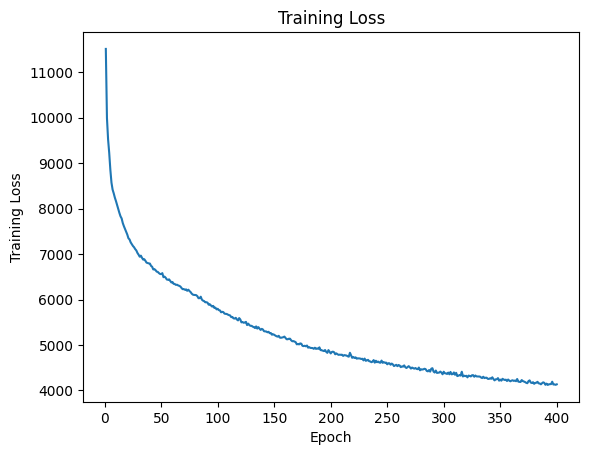

ValueError: x and y must have same first dimension, but have shapes (400,) and (800,)

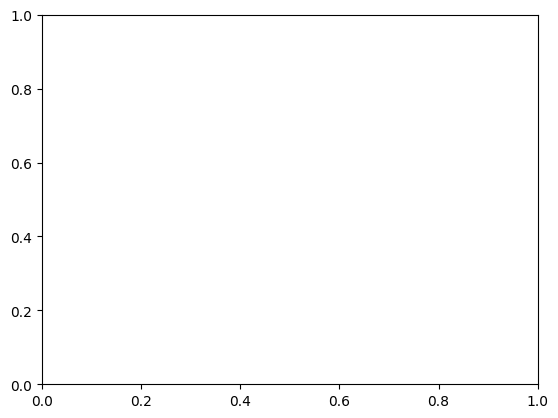

In [26]:

# 绘制训练损失图
plt.plot(range(1, num_epochs+1), train_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()

# 绘制训练精度和验证精度图
plt.plot(range(1, num_epochs+1), train_accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()
plt.plot(range(1, num_epochs+1), val_accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()